# Vectorial Word Representations

## Background
Representing words as dense vectors over a finite-dimensional space was one of the recent breakthroughs in Natural Language Processing. Vectorial representations allow space-efficient, informationally rich storage of words that adequately captures their semantic content and enables numerical computation on them. Word vectors are the standard input representation for machine learning architectures for language processing. Even though new methods for constructing such representations emerge frequently, the original set of published papers remain a de facto point of reference as well as a good starting point. For this assignment, you will be asked to implement a small-scale variant of one such paper, namely [Global Word Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) ("the GloVe paper").

Notes on the paper will appear throughout the notebook to guide you along the code. It is, however, important to read and understand the paper, its terminology and the theory behind it before attempting to go through with the assignment. Some of the tasks will also require addressing the paper directly.

---

There are 2 types of tasks in this assignment:
- coding tasks --- asking you to write code following specifications provided; Most of the tasks come with test cases for sanity-check. Still, if something is not clear, <ins>do ask questions to lab teachers</ins>.
- interpretation questions --- asking you to interpret the data or the results of the model

Each comes with its predefined points (totaling to 16pt). Some coding tasks have 0 points but solving them will be useful for you.

---

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` cell and keep the header(!).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily means that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debuging/testing purposes.
* Don't forget to fill in the contribution information.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>


# <font color="red">Contributions</font>


* Andreas Alexandrou, Sotiris Zenios
* All subsections where completed in pair-programming sessions together in order to better understand all the material

## Corpus Statistics

The paper's proposed model, GloVe, aims to densely represent words in a way that captures the global corpus statistics.

The construction it encodes is the word __co-occurrence matrix__. A co-occurrence matrix is a simplistic data structure that counts the number of times each word has appeared within the context of every other word. The definition of a context varies; usually, context is implied to be a fixed-length span (that may or may not be allowed to escape sentence boundaries) around a word.

For instance, in the sentence below and for a context length of 2, the word <span style="color:pink">__Earth__</span> occurs in the context of <span style="color:lightgreen">made</span> (1), <span style="color:lightgreen">on</span> (1), <span style="color:lightgreen">as</span> (1), <span style="color:lightgreen">an</span> (1).

> "He struck most of the friends he had <span style="color:lightgreen">made on</span> <span style="color:pink">__Earth__</span> <span style="color:lightgreen">as an</span> eccentric"

Similarly, the word <span style="color:pink">__friends__</span> occurs in the context of <span style="color:lightgreen">of</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">he</span> (1), <span style="color:lightgreen">had</span> (1).

> "He struck most <span style="color:lightgreen">of the</span> <span style="color:pink">__friends__</span> <span style="color:lightgreen">he had</span> made on Earth as an eccentric"

An alternative definition of a context would be, for instance, the variable-length windows spanned by a full sentence.

Contexts may be summed across sentences or entire corpora; the summed context of <span style="color:pink">he</span> in the example sentence is: <span style="color:lightgreen">struck</span> (1), <span style="color:lightgreen">most</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">friends</span> (1), <span style="color:lightgreen">had</span> (1), <span style="color:lightgreen">made</span> (1).



For the purposes of this assignment, we have prepared a co-occurrence matrix over a minimally processed version of the Harry Potter books.

(A few interpretation tasks in this assignment presuppose some minimal level of familiarity with the Harry Potter books/films. If no one in your group is familiar with Harry Potter, you might find the [fandom page](https://harrypotter.fandom.com/wiki/Main_Page) useful or the [synopsis sections](https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone) of the corresponding wiki pages.

The pickle file contains three items:
1. `vocab`: a dictionary mapping words to unique ids, containing $N$ unique words
2. `contexts`: a dictionary mapping words to their contexts, where contexts are themselves dicts from words to integers that show the number of co-occurrences between these words.
    E.g. `{"portrait": {"harry": 124, "said": 114, ...}, ...}` meaning that the word "harry" has appeared in the context of the word "portrait" 124 times, etc.
3. `X`: a torch LongTensor ${X}$ of size $N \times N$, where ${X}[i,j]$ denotes the number of times the word with id $j$ has appeared in the context of the word with id $i$

Extremely common or uncommon words (i.e. words with too few or too many global occurrences) have been filtered out for practical reasons.

In [ ]:
import pickle
import torch
from torch import FloatTensor, LongTensor
from typing import Dict, Callable, List
# torch.set_printoptions(precision=8) #to increase precision of printing floats

In [ ]:
# this command downloads the pickle file.
# This is not a python code, it is a unix code. You can run system commands in jupyter notebooks.
!wget -nv -O HP-Counts.p https://www.dropbox.com/scl/fi/dnm7s38j8d0k0bguisiby/HP-Counts.p?rlkey=j0fc11rlnkow7jqb02sel6gz6&dl=1

2023-11-01 18:43:05 URL:https://uc5447531e80184c111b5c87a272.dl.dropboxusercontent.com/cd/0/inline/CGto1CovKaxSQzZ2zOK6_G9fpWr0G41dCuCNmwJ_r5TlQM5ux0S8p48BWPG3GIjMGzD8ZikujJoWTPYl53KkImVt-wQdrfC9s_CbaXjP8D0bwpSY2jGE7gbbRPVe8FJG7Xc/file [173580603/173580603] -> "HP-Counts.p" [1]


In [ ]:
with open("HP-Counts.p", "rb") as f:
    vocab, contexts, X = pickle.load(f)


Let's inspect the top 10 most frequent words in the context of the word 'portrait'.

In [ ]:
sorted([(item, value) for item, value in contexts["portrait"].items()], key=lambda x: x[1], reverse=True)[:10]

[('harry', 124),
 ('said', 114),
 ('hole', 85),
 ('ron', 57),
 ('hermione', 54),
 ('room', 48),
 ('fat', 45),
 ('lady', 43),
 ('common', 37),
 ('back', 31)]

The co-occurrence matrix of a very large corpus should give a meaningful summary of how a word is used in general. A single row of that matrix is already a __word vector__ of size $N$. However such vectors are extremely sparse, and for large corpora the size of $N$ will become unwieldy. We will follow the paper in designing an algorithm that can compress the word vectors while retaining most of their informational content.

<div class="alert alert-block alert-info">
<b>Note:</b>
For the resulting vectors to actually be informative, the source corpus should have a size of at least a few billion words; on the contrary, our corpus enumerates merely a million words, so we can't expect our results to be as great.
</div>

### From co-occurrence to probabilities

Our matrix $X$ is very sparse; most of its elements are zero.

Find what the ratio of non-zero elements is.  
Check if the matrix is symmetric (think about why it should (not) be).

_Hint_: The function `non_zero_ratio` should return a `float` rather than a `FloatTensor`. Remember `.item()`.

In [ ]:
# @title c1.1 [0pt]
def non_zero_ratio(sparse_matrix: LongTensor) -> float:
    non_zero_count = sum(1 for row in sparse_matrix for value in row if value != 0)
    total_items = sum(len(row) for row in sparse_matrix)
    return(float(non_zero_count)/float(total_items))


In [ ]:
# TEST c1.1
assert 0.1 < non_zero_ratio(X) < 0.2

We will soon need to perform division and find the logarithm of ${X}$. Neither of the two operations are well-defined for $0$. That's why for further processing we want to have a matrix without any zero elements.

Change the matrix's datatype to a `torch.float` and add a small constant to it (e.g. $0.1$) to ensure numerical stability while maintaining sparsity. The obtained matrix will be used in the remaining sections (not the original one).

In [ ]:
# @title c1.2 [.25pt]
X1 = X.to(torch.float)
X1 = X1 + 0.1
print(X1)

tensor([[3.4100e+01, 1.1000e+00, 1.0000e-01,  ..., 1.0000e-01, 5.1000e+00,
         1.0000e-01],
        [1.1000e+00, 1.0000e-01, 1.0000e-01,  ..., 4.1000e+00, 1.0000e-01,
         1.0000e-01],
        [1.0000e-01, 1.0000e-01, 1.0000e-01,  ..., 1.1000e+00, 1.0000e-01,
         1.0000e-01],
        ...,
        [1.0000e-01, 4.1000e+00, 1.1000e+00,  ..., 1.3001e+03, 1.0000e-01,
         1.0000e-01],
        [5.1000e+00, 1.0000e-01, 1.0000e-01,  ..., 1.0000e-01, 5.2410e+02,
         6.1000e+00],
        [1.0000e-01, 1.0000e-01, 1.0000e-01,  ..., 1.0000e-01, 6.1000e+00,
         4.1000e+00]])


In [ ]:
# TEST c1.2
assert non_zero_ratio(X1) == 1

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

From the paper:
> Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$.  Let $X_i$= $\sum_{k} X_{ik}$ be the number of times any word appears in the context of word $i$. Finally, let $P_{ij} = P(j  | i) =  X_{ij}/X_i$ be the probability that word $j$ appears in the context of word $i$.

Complete the function `to_probabilities` that accepts a co-occurrence matrix and returns the probability matrix $P$.

_Hint_: Remember broadcasting and `torch.sum()`.

In [ ]:
# @title c1.3 [.25pt]
def to_probabilities(count_matrix: FloatTensor) -> FloatTensor:
    row_sums = torch.sum(count_matrix,dim=1,keepdim=True)
    return count_matrix/row_sums




In [ ]:
P = to_probabilities(X1) # note that we use X1 not X here

In [ ]:
# TEST c1.3
assert P.shape == torch.Size([len(vocab), len(vocab)])

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### Probing words

From the paper:
> Consider two words $i$ and $j$ that exhibit a particular aspect of interest. The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$.  For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large.  Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one.

Complete the function `query` that accepts two words $w_i$ and $w_j$, a vocab $V$ and a probability matrix ${P}$, maps each word to its corresponding index and returns the probability $P(j  |  i)$. If such probability is impossible to compute for input words, return float 0. probability.  

In [ ]:
# @title c2.1 [.25pt]
def query(word_i: str, word_j: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
    wi = vocab[word_i]
    wj = vocab[word_j]
    return float(prob_matrix[wi][wj])


In [ ]:
# TEST c2.1
assert round(query('harry', 'potter', vocab, P), 5) == 0.00353

Then, complete the function `probe` that accepts three words $w_i$, $w_j$ and $w_k$, a vocab $V$ and a probability matrix ${P}$, calls `query` and returns the ratio $P(k |  i) / P(k  |  j)$.

In [ ]:
# @title c2.2 [.25pt]
def probe(word_i: str, word_j: str, word_k: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
    return query(word_i,word_k,vocab,prob_matrix)/query(word_j,word_k,vocab,prob_matrix)

In [ ]:
# TEST c2.2
assert round(probe('harry', 'potter', 'stone', vocab, P), 4) == 1.3872

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

Let's probe a few words and examine whether the authors' claim holds even for our (tiny) corpus. **Add two pairs of your own word triplets** and experiment on them.

In [ ]:
print("tea", "wand", "magic", probe("tea", "wand", "magic", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()
# YOUR CODE HERE

print("harry", "water", "portrait", probe("harry", "water", "portrait", vocab, P))
print("harry", "hermione", "portrait", probe("harry", "hermione", "portrait", vocab, P))

tea wand magic 0.018442942510795767
tea wand cup 26.14265487166853

harry water portrait 19.556077127097197
harry hermione portrait 0.6677205631116542


#### i1 [1pt]
Give a brief interpretation of the results you got. Do they correspond to your expectations? Why or why not?

*Hint*: When do we expect the ratio value to be high, low or close to 1? Refer to the GloVe paper for guidance.

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

The correlation between "harry" and "portrait" with "water" and "potrait" is high around 20. That shows that "harry" is highly assossiated with "portrait" but its assossiation with "water" is not as high. This is because as we saw in at the begining of the asssignment the word "portrait" has the word "harry" as the most frequent word, while the word "water" has a low appearance ratio. For the other example we can see that both words are either related to "portrait", thats why the ratio its close to one.

What would happen if we tried probing out-of-domain words? Use the words that the authors report in the paper in the context of "ice" and "steam" (Table 1). Make your code to clearly print the details.

In [ ]:
# YOUR CODE HERE
print("ice", "steam", "solid", probe("ice", "steam", "solid", vocab, P))
print("ice", "steam", "gas", probe("ice", "steam", "gas", vocab, P))
print("ice", "steam", "water", probe("ice", "steam", "water", vocab, P))
print("ice", "steam", "fashion", probe("ice", "steam", "fashion", vocab, P))

#P(k|ice)/P(k|steam)    8.9    8.5 × 10−2     1.36    0.96

ice steam solid 0.07830312620153405
ice steam gas 0.8613343808912856
ice steam water 1.27149363325054
ice steam fashion 0.8613343808912856


#### i2 [1pt]
Give an interpretation of the results you got. Do they match what the authors report in the paper? Why or why not?

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

As we can see in the first example, in our dataset the word "solid" has a higher assossiation with the word "steam", where as in the paper it is implied that the word "solid" has a higher assossiation with the word "ice".
In the second example, in our dataset the word "gas" with the other two words has either the same assossiation with both words or not. In the paper, it is implied that the word "gas" has higher assossiation with the word "steam" rather than the word "ice".
The last two examples show similar results.
The difference in the first two examples might be caused because of the specific context of the harry potter dataset.  



## Dense Vectors

Now, we would like to convert these long sparse vectors into short dense ones.

The conversion should be such that the probability ratios we inspected earlier may still be reconstructed via some (for now, unknown) operation $F$ on the dense vectors.

To restrict the search space over potential functions, the authors impose a number of constraints they think $F$ should satisfy:
1. > While $F$ could be taken to be a complicated function parameterized by, e.g., a neural network, doing so would obfuscate the linear structure we are trying to capture. $F$ should be dot-product based.
2. > The distinction between a word and a context word is arbitrary and we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$ but also $X \leftrightarrow X^T$.
3. > It should be well-defined for all values in $X$.

Given these three constraints, each word $i$ in our vocabulary is represented by four vectors:
1. A vector $w_i \in \mathbb{R}^D$
2. A bias $b_i \in \mathbb{R}$
3. A context vector $\tilde{w}_i \in \mathbb{R}^D$
4. A context bias $\tilde{b}_i \in \mathbb{R}$

and $F: \mathbb{R}^D \times \mathbb{R} \times \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}$ is defined as:

$F(w_i, \tilde{w}_k, b_i, \tilde{b}_k) = w_i^T\tilde{w}_k + b_i + \tilde{b}_k$.

Or equivalently the least squares error $J$ is minimized, where:

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_{i}^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

with $f$ being a weighting function, defined as

$f: \mathbb{R} \to \mathbb{R} = \begin{cases}
    (x/x_{max})^\alpha, & \text{if $x<x_{max}$}\\
    1, & \text{otherwise}.
  \end{cases}$

### Weighting Function

Let's start with the last part.

Complete the weighting function `weight_fn` which accepts a co-occurrence matrix ${X}$, a maximum value $x_{max}$ and a fractional power $alpha$, and returns the weighted co-occurrence matrix $f({X})$.

Then, compute $\text{X_weighted}$, the matrix ${X}$ after weighting, using the paper's suggested parameters.

_Hint_: Note that $f$ is defined pointwise, so our weighting function should also be pointwise.

In [ ]:
# @title c3 [.25pt]
def weight_fn(X: FloatTensor, x_max: int, alpha: float) -> FloatTensor:
    weights = torch.where(X < x_max, (X / x_max) ** alpha, torch.tensor(1.0))
    return weights




In [ ]:
X_weighted = weight_fn(X1, x_max=100, alpha=3/4)


In [ ]:
# TEST c3
assert X_weighted.shape == X1.shape

Try to get an understanding of how the weighting affects different co-occurrence values (high and low). Think of some word pairs with high and low co-occurrence and look them up in $X$ and in $\text{X_weighted}$ to get a better idea.

In [ ]:
# YOUR CODE HERE
P = to_probabilities(X1)
P1 = to_probabilities(X_weighted)

print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P1))
print("ice", "steam", "solid", probe("ice", "steam", "solid", vocab, P))
print("ice", "steam", "solid", probe("ice", "steam", "solid", vocab, P1))

tea wand cup 26.14265487166853
tea wand cup 11.36323389018632
ice steam solid 0.07830312620153405
ice steam solid 0.1498288874297237


### Loss Function

The next step is to write the loss function.

We can write it as a pointwise function, apply it iteratively over each pair of words and then sum the result; that's however extremely inefficient.

Inspecting the formulation of $J$, it is fairly straightforward to see that it can be immediately implemented using matrix-matrix operations, as:

$J = \sum_{i,j=1}^{V}f(\mathbf{X})\cdot(W\tilde{W}^T + b + \tilde{b}^T - log(X))^2$,

where $W$, $\tilde{W}$ are the $N \times D$ matrices containing the $D$-dimensional vectors of all our $N$ vocabulary words, and $b$, $\tilde{b}$ are the $N \times 1$ matrices containing the $1$-dimensional biases of our words.

Complete `loss_fn`, a function that accepts a weighted co-occurrence matrix $f({X})$, the word vectors and biases $W$, $\tilde{W}$, $b$, $\tilde{b}$ and the co-occurrence matrix ${X}$, and computes $J$.

In [ ]:
# @title c4 [.25pt]
def loss_fn(
    X_weighted: FloatTensor,
    W: FloatTensor,
    W_context: FloatTensor,
    B: FloatTensor,
    B_context: FloatTensor,
    X: FloatTensor
) -> FloatTensor:
   x = ((torch.mm(W, W_context.t()) + B + B_context.t() - torch.log(X))**2) * X_weighted
   J = torch.sum(x)
   return J



Let's make sure that we are on a right track. For this we calculate the loss function with toy input: matrices are of size $2 \times 2$ while bias vectors of size $2 \times 1$. You can verify the answer manually and with your implementation of `loss_fn`.

In [ ]:
# TEST c4
toy_X_weighted = torch.FloatTensor([[.5,1],[.2,.1]])
toy_X1 = torch.FloatTensor([[2,1],[1,5]])
toy_W1 = torch.FloatTensor([[1,2],[1,0]]) # for W
toy_W2 = torch.FloatTensor([[0,1],[1,2]]) # for W~
toy_b1 = torch.FloatTensor([[0],[2]]) # for b
toy_b2 = torch.FloatTensor([[2],[1]]) # for b~

loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1)
# fill the correct value
# assert loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1).isclose(FloatTensor([???]))

tensor(45.2391)

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### GloVe

We have the normalized co-occurrence matrix ${X}$, the weighting function $f$, and the loss function $J$ that implements $F$.

What we need now is a mapping from words (or word ids) to unique, parametric and trainable vectors.

Torch provides this abstraction in the form of [Embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding). Each such layer may be viewed as a stand-alone network that can be optimized using the standard procedure we have already seen. It is recommended to read about Embedding class  

We will utilize the `nn.Module` class to contain all our embedding layers and streamline their joint optimization.
The container class will be responsible for a few things:

1. Wrapping the embedding layers:
    1. A vector embedding that maps words to $w \in \mathbb{R}^D$
    2. A context vector embedding that maps words to $w_c \in \mathbb{R}^D$
    3. A bias embedding that maps words to $b \in \mathbb{R}^1$
    4. A context bias embedding that maps words to $b_c \in \mathbb{R}^1$
2. Implementing `forward`, a function that accepts a weighted co-occurrence matrix $f(X)$, the co-occurrence matrix $X$, then finds the embeddings of all words and finally calls `loss_fn` as defined above.
3. Implementing `get_vectors`, a function that receives no input and produces the word vectors and context word vectors of all words, adds them together and returns the result, in accordance with the paper:
> ...With this in mind, we choose to use the sum $W + \tilde{W}$ as our word vectors.

Complete the network class following the above specifications.  

In [ ]:
# @title c5 [1.5pt]
class GloVe(torch.nn.Module):
    def __init__(self, vocab: Dict[str, int], vector_dim: int=30, device: str="cpu", seed: int=0) -> None:
        super(GloVe, self).__init__()
        self.device = device
        self.vocab_len = len(vocab)
        torch.manual_seed(seed)
        self.w = torch.nn.Embedding(self.vocab_len, vector_dim).to(device)
        self.wc = torch.nn.Embedding(self.vocab_len, vector_dim).to(device)
        self.b = torch.nn.Embedding(self.vocab_len, 1).to(device)
        self.bc = torch.nn.Embedding(self.vocab_len, 1).to(device)

    def forward(self, X_weighted: FloatTensor, X: FloatTensor) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        return loss_fn(X_weighted, W, self.wc(embedding_input),self.b(embedding_input),self.bc(embedding_input), X)

    def get_vectors(self) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        return  self.w(embedding_input) + self.wc(embedding_input)


In [ ]:
# TEST c5
assert GloVe(vocab, vector_dim=30, seed=0).w.num_embeddings == len(vocab)
assert GloVe(vocab, vector_dim=30, seed=0).bc.num_embeddings == len(vocab)

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

Training

Everything is in place; now we may begin optimizing our embedding layers (and in doing so, the vectors they assign).

Instantiate the network class you just defined using $D = 30$. Then instantiate an `Adam` optimizer with a learning rate of 0.05 and train your network for 300 epochs (don't change the default seed value).

When writing the training script, remember that your network's forward pass is __already__ computing the loss. Make sure to print a loss value for each epoch.

Training won't take too long on a CPU. In case you want to use a GPU, make sure that variables are correctly moved to a GPU with a `device` argument of class `GloVe`.

In [ ]:
# @title c6.1 [1pt]
import torch.optim as optim
network = GloVe(vocab, vector_dim=30, device="cpu", seed=0)
opt = optim.Adam(network.parameters(), lr=0.05)

In [ ]:
%%time
num_epochs = 300
losses = [] # collect losses for each epoch here
for i in range(num_epochs):
    loss = network.forward(X_weighted, X1) # loss computation (optionally print it out), remember to use X1 counts not X
    # opt.zero_grad()
    loss.backward()   # gradient computation
    opt.step()# back-propagation
    opt.zero_grad()  # gradient reset

    # Collect losses
    losses.append(loss.item())

    print(f"Epoch {i + 1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/300, Loss: 11233914.0
Epoch 2/300, Loss: 9747190.0
Epoch 3/300, Loss: 8462501.0
Epoch 4/300, Loss: 7357555.5
Epoch 5/300, Loss: 6410067.0
Epoch 6/300, Loss: 5599318.5
Epoch 7/300, Loss: 4906458.0
Epoch 8/300, Loss: 4314543.5
Epoch 9/300, Loss: 3808523.5
Epoch 10/300, Loss: 3375189.0
Epoch 11/300, Loss: 3003075.5
Epoch 12/300, Loss: 2682324.0
Epoch 13/300, Loss: 2404525.75
Epoch 14/300, Loss: 2162565.0
Epoch 15/300, Loss: 1950476.625
Epoch 16/300, Loss: 1763321.75
Epoch 17/300, Loss: 1597080.75
Epoch 18/300, Loss: 1448565.125
Epoch 19/300, Loss: 1315332.125
Epoch 20/300, Loss: 1195598.5
Epoch 21/300, Loss: 1088134.625
Epoch 22/300, Loss: 992130.125
Epoch 23/300, Loss: 907028.25
Epoch 24/300, Loss: 832340.375
Epoch 25/300, Loss: 767473.4375
Epoch 26/300, Loss: 711620.3125
Epoch 27/300, Loss: 663749.5
Epoch 28/300, Loss: 622689.375
Epoch 29/300, Loss: 587262.0
Epoch 30/300, Loss: 556409.75
Epoch 31/300, Loss: 529274.625
Epoch 32/300, Loss: 505218.1875
Epoch 33/300, Loss: 483793.37

Note that if you want to re-run the training process from scratch, remember that you also need to redefine `network` otherwise your training will continue from the last epoch's training state.  
<font color="red">**Don't clear the output of the above cell!**</font>

In [ ]:
# TEST c6.1
assert len(losses) == 300
assert losses[0] > losses[-1]

Plot the losses (x axis for epoch number and y axis for loss) and examine the learning curve. Ask yourself, is its shape what you would expect it to be?

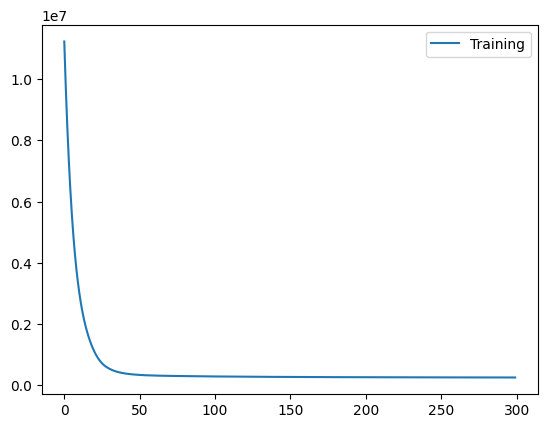

In [ ]:
# @title c6.2 [0pt]
from matplotlib import pyplot as plt
plt.plot(losses)
plt.legend(["Training"])
plt.show()

<font color="red">**Don't clear the output of the above cell!**</font>

### Validation (Similarity)

Curious to see what this network has learned? Let's perform a simple validation experiment.

We will check which words the model considers the most similar to other words. To that end, we need a notion of __similarity__. One of the most common measures of similarity in high-dimensional vector spaces is the cosine similarity.

The cosine similarity of two vectors $\vec{a}, \vec{b}$ is given as:
$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot \vec{b}}{|\vec{a}|_2 \cdot |\vec{b}|_2}$$

where $|\vec{x}|_2$ is the $L_2$-norm of the $\vec{x}$.

The function `similarity` below accepts two words, a vocabulary and the network's output vectors, and computes the similarity between these two words. For an outside-vocabulary word similarity is 0.

In [ ]:
def similarity(word_i: str, word_j: str, vocab: Dict[str, int], vectors: FloatTensor) -> float:
    if not(word_i in vocab and word_i in vocab): return 0.
    i = vocab[word_i]
    j = vocab[word_j]
    v_i = vectors[i] / torch.linalg.vector_norm(vectors[i])  # a/|a|
    v_j = vectors[j] / torch.linalg.vector_norm(vectors[j])  # b/|b|
    sim = torch.mm(v_i.view(1, -1), v_j.view(-1, 1)).item()
    # sim = sim = torch.dot(v_i, v_j)
    return sim

Let's check out some examples. Consider the word pairs below and, optionally, add your own word pairs if it helps to support your answer:

In [ ]:
word_vectors = network.get_vectors().detach()

for pair in [
    ("cruciatus", "imperius"),
    ("avada", "kedavra"),
    ("hogwarts", "school"),
    ("goblin", "hagrid"),
    ("giant", "hagrid"),
]:
    print(f"Similarity between '{pair[0]}' and '{pair[1]}' is: {similarity(pair[0], pair[1], vocab, word_vectors)}")

Similarity between 'cruciatus' and 'imperius' is: 0.4987606406211853
Similarity between 'avada' and 'kedavra' is: 0.6552069187164307
Similarity between 'hogwarts' and 'school' is: 0.7654939293861389
Similarity between 'goblin' and 'hagrid' is: 0.27460333704948425
Similarity between 'giant' and 'hagrid' is: 0.5027310848236084


#### i3 [1pt]
Give an interpretation of the results. Do the scores correspond well to your perceived similarity of these word pairs?

**ANSWER**: 'cruciatus' and 'imperius' (0.499): These are both names of curses in the Harry Potter series, so we would expect them to have contextual similarity. A score of about 0.5 suggests a moderate level of similarity, indicating that while they aren't identical, the model recognizes common context or usage.

'avada' and 'kedavra' (0.655): These two words form "Avada Kedavra," another spell from Harry Potter, and are almost always used together, hence the higher similarity score. This shows that the model has effectively learned the strong association between these two words.

'hogwarts' and 'school' (0.765): Hogwarts is the primary setting for the Harry Potter series and is a school. The high similarity score indicates that the model has successfully learned this context and understands that 'Hogwarts' is very closely related to the concept of a 'school.'

'goblin' and 'hagrid' (0.275): While both terms are from the Harry Potter universe, goblins and Hagrid (a specific character) aren't directly related. Hagrid is a half-giant, not a goblin. The low similarity score reflects the model's recognition that these words are not used in similar contexts.

'giant' and 'hagrid' (0.503): Hagrid is a half-giant in the Harry Potter series. The moderate similarity score here suggests that the model somewhat recognizes the relationship between 'Hagrid' and 'giant,' but they don't have a strong association in the text data the model was trained on (perhaps because there are many other contexts in which 'giant' is used beyond discussing Hagrid).

To obtain the similarities of one word against all other words in the corpus, use torch functions and follow the equation ($\vec{c}_i$ is $i$th row of $\mathbf{C}$):
$$sim(\vec{w}, \mathbf{C}) = \frac{\vec{w}\cdot \mathbf{C}}{|\vec{w}|_2 \cdot |\mathbf{C}|_2} = \Big(\frac{\vec{w}\cdot \vec{c}_1}{|\vec{w}|_2 \cdot |\vec{c}_1|_2},\ldots,\frac{\vec{w}\cdot \vec{c}_N}{|\vec{w}|_2 \cdot |\vec{c}_N|_2}\Big)$$

Using `similarity` as a reference, write `similarities`, which accepts one word, a vocabulary and the network's output vectors and computes the similarity between the word and the entire corpus. If a word is out of vocabulary, it should return a matrix of 0 similarities.

_Hint_: $\mathbf{C} \in \mathbb{R}^{N, D}$, $\vec{w} \in \mathbb{R}^{1, D}$, $sim(\vec{w}, \mathbf{C}) \in \mathbb{R}^{1, N}$

In [ ]:
# @title c7 [1.5pt]
def similarities(word_i: str, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
    # use torch functions. Don't iterate over rows of vectors matrix!
    if word_i not in vocab:
      return torch.zeros(1, len(vocab))
    word_index = vocab[word_i]
    word_vector = vectors[word_index]
    dot_products = torch.mv(vectors, word_vector)
    # Compute the norm of the word vector
    word_norm = torch.norm(word_vector)
    # Compute the norm of all vectors in the corpus
    corpus_norms = torch.norm(vectors, dim=1)
    similarities = dot_products / (word_norm * corpus_norms)

    return similarities.view(1, -1)

In [ ]:
# TEST c7a
print(similarities('harry', vocab, word_vectors).shape)
print(torch.Size([1, len(vocab)]))
assert similarities('harry', vocab, word_vectors).shape == torch.Size([1, len(vocab)])
assert similarities('cow', vocab, word_vectors).shape == torch.Size([1, len(vocab)])

torch.Size([1, 4298])
torch.Size([1, 4298])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

Now we can manipulate the word vectors to find out what the corpus-wide most similar words to a query word are!

In [ ]:
def most_similar(word_i: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    """ Returns a list of k words that are most similar to word_i
        The list excludes word_i itself
    """
    sims = similarities(word_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k+1)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_i][:k]

In [ ]:
# TEST c7b
for word in [
    "forbidden", "myrtle", "gryffindor", "wand", "quidditch", "marauder",
    "horcrux", "phoenix", "triwizard", "screaming", "letter"
]:
    print(f"Most similar words to '{word}': {most_similar(word, vocab, word_vectors, 6)}")

Most similar words to 'forbidden': ['shadows', 'grounds', 'forest', 'lawns', 'mountains', 'ahead']
Most similar words to 'myrtle': ['moaning', 'bathroom', 'hid', 'toilet', 'sobbing', 'properly']
Most similar words to 'gryffindor': ['ravenclaw', 'team', 'wood', 'possession', 'quidditch', 'beat']
Most similar words to 'wand': ['spoke', 'face', 'shot', 'onto', 'struggled', 'flew']
Most similar words to 'quidditch': ['winning', 'saturday', 'team', 'training', 'captain', 'seeker']
Most similar words to 'marauder': ['lucky', 'gotten', 'convinced', 'map', 'locked', 'set']
Most similar words to 'horcrux': ['sword', 'object', 'goblin', 'destroy', 'horcruxes', 'safe']
Most similar words to 'phoenix': ['feather', 'fawkes', 'spinning', 'building', 'connected', 'murder']
Most similar words to 'triwizard': ['tournament', 'champions', 'cedric', 'cup', 'champion', 'quidditch']
Most similar words to 'screaming': ['frozen', 'scream', 'voices', 'screams', 'cold', 'forced']
Most similar words to 'letter':

#### i4 [1pt]

Interpret the results in the context of Harry Potter books.
- Do these most similar words make sense (are they actually similar to the query words)?
- Are there any patterns you can see in the "errors" (the words that you wouldn't consider actually similar to the query word in general, in everyday life)?
- Which examples are instances of similarity (if any) and relatedness (if any)?
- Any other observations are welcome.

Illustrate your answers with examples from your model's output.

**ANSWER**:  <font color="red">YOUR ANSWER HERE</font>

 i)'forbidden': Words like 'grounds', 'forest', 'lawns', 'mountains', and 'ahead' make sense as they are related to the Forbidden Forest in the books.

'myrtle': 'Moaning', 'bathroom', 'toilet', 'sobbing' are related to the character Moaning Myrtle who is  associated with bathrooms and crying.

'gryffindor': 'Ravenclaw', 'team', 'quidditch', 'beat' are all relevant to the Hogwarts Gryffindor houseand its activities.

'wand': This doesn't seem very  accurate, even though 'spoke' and 'shot' could be related to spells with a wand.

'triwizard': 'Tournament', 'champions', 'cedric', 'cup', 'champion' are all very highly relevant to the Triwizard Tournament.

ii)Some errors can be seen from words that are contextually related in the books but don't have a similar meaning outside of that. E.g.:

'wand' and 'flew' are related in the context of magic but not in general everyday life.
'phoenix' and 'murder' are related through the story  but are not similar in everyday context.

iii)Similarity: 'letter' and 'letters', 'screaming' and 'scream' show lexical similarity. They are similar in their form and their meaning.

Relatedness: 'gryffindor' and 'quidditch', 'myrtle' and 'bathroom', 'triwizard' and 'tournament' demonstrate semantic relatedness. They aren't close in meaning but are part of the same context in the Harry Potter books.

All in all,the findings suggest that the model effectively identified relevant semantic connections within the Harry Potter texts, with the similarity of certain words corresponding in a logical way to the context of the story.Bus the model does not comprehend the real life correlations between words or understand the Harry Potter universe as humans do.

Overall it's quite impressive; we managed to encode a meaningful portion of the corpus statistics in only $30$ numbers per word!
(A compression ratio of >99%)

<div class="alert alert-block alert-info">
<b>Note:</b> The word vectors obtained by this process are (to a small extent) random, due to the random initialization of the embedding layers. If you are unhappy with your results, you can repeat the experiment a few times or try to toy around with the hyper-parameters (the smoothing factor of ${X}$, $x_{max}$, $\alpha$, the number of epochs and the dimensionality of the vector space).
</div>

Word vectors, however, contain way more information than just word co-occurrence statistics. Hold tight until the next assignment, where we will see how word vectors may be used to infer information spanning entire phrases and sentences.

### Validation (Word Analogies)

From the paper:
> The word analogy task consists of questions like "$a$ is to $b$ as is $c$ to $?$" To correctly answer this question, we must find the word $d$ such that $w_d \approx w_b - w_a + w_c$ according to the cosine similarity.

Write your own function that performs the word analogy task.

_Hint_: Take a look at the code a few cells back. Most of what you need is already there.

In [ ]:
# @title c8 [1.5pt]
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int], vectors: FloatTensor, k: int
) -> List[str]:
    """ Return a list of k words whose vectors are most similar to the solution vector of the analogy.
        word_a, word_b, and word_c are never returned as a part of the list
    """
    if any(word not in vocab for word in [word_a, word_b, word_c]):
        raise ValueError("One or more words are not in the vocabulary.")

    # Get the vectors for words a, b, and c
    vector_a = vectors[vocab[word_a]]
    vector_b = vectors[vocab[word_b]]
    vector_c = vectors[vocab[word_c]]

    # Calculate the solution vector using the analogy formula
    solution_vector = vector_b - vector_a + vector_c

    # Normalize the solution vector
    solution_vector = solution_vector / solution_vector.norm()

    # Find the word that is closest to the solution vector
    similarities = torch.mv(vectors, solution_vector)
    closest_word_idx = torch.argmax(similarities).item()
    closest_word = next(key for key, value in vocab.items() if value == closest_word_idx)

    # Exclude the input words from the results
    original_words = {word_a, word_b, word_c}

    # Get the most similar words to the closest word
    most_similar_words = most_similar(closest_word, vocab, vectors, k + len(original_words))  # Request extra words because we'll remove some

    # Remove the original words and the closest word from the similar words list
    final_words = [word for word in most_similar_words if word not in original_words and word != closest_word]

    return final_words[:k]


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

Some example triplets to test your analogies on:

In [ ]:
# TEST c8
triplets = [("padma", "parvati", "fred"),
            ("avada", "kedavra", "expecto"),
            ("dungeon", "slytherin", "tower"),
            ("scabbers", "ron", "hedwig"),
            ("ron", "molly", "draco"),
            ("durmstrang", "viktor", "beauxbatons"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron"),

            ("magic", "harry", "ron"),
            ("hermione", "said", "portrait"),
            ("stick", "toilet", "draco"),
           ]

for a, b, c in triplets:
    print("'{}' is to '{}' as '{}' is to {}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 6)))

'padma' is to 'parvati' as 'fred' is to ['george', 'okay', 'percy', 'prefect', 'together', 'ron']
'avada' is to 'kedavra' as 'expecto' is to ['patronum', 'dementor', 'slowed', 'patronus', 'stag', 'move']
'dungeon' is to 'slytherin' as 'tower' is to ['match', 'johnson', 'slytherins', 'hundred', 'seeker', 'beaten']
'scabbers' is to 'ron' as 'hedwig' is to ['cage', 'errol', 'owl', 'beak', 'pigwidgeon', 'letter']
'ron' is to 'molly' as 'draco' is to ['cornelius', 'minister', 'prime', 'ministry', 'evidence', 'presence']
'durmstrang' is to 'viktor' as 'beauxbatons' is to ['krum', 'madame', 'bulgarian', 'tournament', 'captain', 'bagman']
'snape' is to 'potions' as 'trelawney' is to ['mcgonagall', 'professor', 'intently', 'binns', 'teacher', 'staff']
'harry' is to 'seeker' as 'ron' is to ['score', 'hoops', 'ireland', 'stands', 'sixty', 'quaffle']
'magic' is to 'harry' as 'ron' is to ['done', 'could', 'nothing', 'seemed', 'look', 'felt']
'hermione' is to 'said' as 'portrait' is to ['password', 

Some minimal emergent intelligence :) *(hopefully..)*. 🧙‍♀️

#### i5 [1pt]

Come up with three additional analogies in the context of Harry Potter.
Add them to the list of analogies in the code above and run the analogy computation.

Interpret the results:
- Did the model manage to guess the correct answers to the analogies (taking the first word in the output to be the model's "guess")?
- Are the correct answers present in the top K words?
- Do you see any patterns in the cases when the model didn't solve the task correctly? In other words, when the model's guess was wrong, can you suggest why the model guessed what it guessed?

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

 For the analogy 'magic' is to 'harry', the expected relationship might be that magic is heavily linked to Harry's identity. The proposed analogy  in relationship for 'Ron' gave words like 'done', 'could', and 'nothing', which are actually the top words when inspecting the top words for 'Ron', which are actions tied to Ron. In the next analogy, 'hermione' is to 'said', the model tries to capture the frequency with which Hermione speaks in the book, yet its analogy with 'portrait' resulted in terms associated with the Gryffindor common room entrance like 'password' and 'fat', but also less directly related terms like 'annoyed'. The last analogy, 'stick' is to 'toilet', isn't a close relationship therefore the output for 'draco' includes 'myrtle' and emotional states like 'delighted' and 'cheerful'. Across these analogies, the model seems to pick up on strong context but also infers relationships based on word occurrences and proximities in the source books. It suggests that while the model can hint at meaningful associations, it's also influenced by the frequency and context of word pairings in the training data, which might not always lead to semantically accurate analogies.

## Counting co-occurrences

In the beginning of the notebook you were provided with a pickle of co-occurrence counts. But how were these counts obtained? You will find this out when you complete this exercise.  

First, we obtain the plain text corpus of the Harry Potter book series and place the book files in the current directory.

In [ ]:
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

Cloning into 'Harry-Potter-Text-Mining'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (109/109), 13.39 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
!cp Harry-Potter-Text-Mining/Book\ Text/* .

In research, it is relatively common that papers don't include all necessary details for replicating the experiments. This is often due to the lack of space in the paper, overlooking certain details, or simply a bad practice.

We will give you several hints on how the co-occurrence matrix was obtained. With the hints and the provided data in the pickle file, you should be able to replicate the exact content of the co-occurrence matrix from the pickle. Here are the hints:

1.   Tokenization of the data was done in a shallow but effective way: replace all punctuations with white space and delimit tokens with a sequence of white spaces;
2.   Standard libraries were used for identifying punctuations and stopwords;
3.   Context windows are symmetric and don't span across chapters (i.e., the last word of chapter $N$ is not co-occuring with the first word of chapter $N+1$).
4.   The vocabulary was obtained based on the frequency cutoff.

To replicate the co-occurrence counts, complete the function below. Then use it to find out the exact values of `cutoff` and `window_size` that result in the co-occurrence counts identical to the provided ones. No need to provide the code for finding the exact values. Just use them in the next TEST code cell.

Feel free to import any standard python library. Use the same cell code for importing libraries and defining auxiliary functions (if any).
The code will be evaluated not only on the correctness of the output but also on efficiency. It should be able to extract the counts and create the tensor in less than a minute (in the colab environment).

In [ ]:
# @title c9 [3pt]
import os
import nltk
import string
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from typing import List, Dict, Tuple
import torch
import re
from collections import defaultdict

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



def read_book_files(files: List[str], cutoff: int=10, window_size: int=20, verbose: bool=False) -> Tuple[Dict[str, int], Dict[str, Dict[str, int]], torch.Tensor]:

    # Create a translation table that keeps "1" but replaces other digits and punctuation with spaces
    exclude_digits = string.digits.replace("1", "")
    translator = str.maketrans(string.punctuation + exclude_digits, ' ' * (len(string.punctuation) + len(exclude_digits)))


    word_freq = Counter()

    # First pass: Build frequency distribution
    for file in files:
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read().lower()
            text = text.translate(translator)
            text = re.sub(r"\b11+\b", " ", text)  # This regex ensures that sequences of "11+" that appear as standalone words are replaced
            words = text.split()
            word_freq.update(words)

    # Filter and sort the vocabulary
    vocab_candidates = {word for word, freq in word_freq.items() if freq >= cutoff and word not in stop_words }
    sorted_vocab = sorted(vocab_candidates)
    voc = {word: idx for idx, word in enumerate(sorted_vocab)}

    dd_cnt = defaultdict(lambda: defaultdict(int))
    total_words = len(voc)
    X = torch.zeros((total_words, total_words), dtype=torch.int64)

    # Second pass: Build co-occurrence matrix and dd_cnt
    for file in files:
      with open(file, 'r', encoding='utf-8') as f:
          text = f.read().lower()
          text = text.replace('"text"@"chapter"@"book"', '')
          chapters = re.split(r'@\d+@\d+', text)

          for chapter in chapters:
              translator = str.maketrans(string.punctuation, ' ' * (len(string.punctuation)))

              chapter = chapter.translate(translator)
              words = [word for word in chapter.split() ]

              for i, word in enumerate(words):
                  word_idx = voc.get(word)
                  if word_idx is not None:
                      start = max(0, i - window_size)
                      end = min(len(words), i + window_size)
                      co_words = words[start:i] + words[i+1:end+1]
                      co_word_counts = Counter(co_words)
                      for co_word, count in co_word_counts.items():
                          co_word_idx = voc.get(co_word)
                          if co_word_idx is not None:
                              dd_cnt[word][co_word] += count
                              X[word_idx, co_word_idx] += count

    return voc, dd_cnt, X


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# TEST c9
# YOUR CODE HERE - Fill in the found cutoff and window_size values
%%time
my_vocab, my_contexts, my_X = read_book_files([ f"HPBook{n}.txt" for n in range(1,8) ],cutoff=16,window_size=25)

CPU times: user 2min 9s, sys: 525 ms, total: 2min 10s
Wall time: 2min 10s


In [ ]:
#TEST COMPARING THE CONTEXT AND X ARRAYS
def compare_dictionaries(dict1, dict2):

    for key in dict1:
        if dict1[key] != dict2[key]:
            print(key)
            print(dict1[key])
            print(dict2[key])
            return False

    return True

def compare_matrices(matrix1, matrix2):
    if matrix1.shape != matrix2.shape:
        return False

    return torch.all(torch.eq(matrix1, matrix2)).item()  # .item() is used to get the value from the tensor



# Now you can compare them
are_dicts_equal = compare_dictionaries(my_contexts, contexts)
are_matrices_equal = compare_matrices(my_X, X)

print(f"Dictionaries are equal: {are_dicts_equal}")
print(f"Matrices are equal: {are_matrices_equal}")

Dictionaries are equal: True
Matrices are equal: True


In [ ]:
#TEST TO CHECK IF BOTH VOCABS ARE THE SAME

# Generate sets from the keys of the dictionaries
vocab_keys = set(my_vocab.keys())
context_keys = set(vocab.keys())  # assuming my_dd_cnt is your 'my_context'

# Find words that are in context_keys but not in vocab_keys
in_context_not_vocab = context_keys - vocab_keys

# Find words that are in vocab_keys but not in context_keys
in_vocab_not_context = vocab_keys - context_keys

# Output the results
print(f"Words in vocab_keys but not in my_vocab_keys: {in_context_not_vocab}")
print(f"Words in my_vocab_keys but not in vocab_keys: {in_vocab_not_context}")

Words in vocab_keys but not in my_vocab_keys: set()
Words in my_vocab_keys but not in vocab_keys: set()


<font color="red">**Don't clear the output of the above cell!**</font>

#### i6 [1pt]

What are the values of `cutoff` and `window_size` that replicates the provided counts?

Briefly describe the process of finding the correct underlying algorithm of `read_book_files` and the correct values of `cutoff` and `window_size`.

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

cutoff=16

window size=25

The goal was to create a co-occurrence matrix from the Harry Potter books, considering specific criteria such as a certain frequency threshold, excluding all stopwords, and only incorporating the number "1" and not other digits. To achieve this, initial efforts focussed on text cleaning: keeping the digit "1", discarding other numbers, and stripping punctuation. This process was further explored to manage sequences where numbers like  "11" appeared. Once the text was prepared, a frequency distribution (word_freq) was created by iterating through each book, using a Counter to keep track. Using this distribution, a  vocabulary (voc) was formed, considering the frequency threshold and removing defined stopwords.

Then moving on to the building the co-occurrence matrix. A sliding window was used: for each word, its adjacent words (within the set window) were pinpointed, and their co-occurrence frequency adjusted. It was essential to view chapters as separate units, preventing cross-chapter word co-occurrence. The solution underwent several refinements, addressing issues like enhanced translation logic, handling chapter separations, and excluding headers such as "Text"@"Chapter"@"Book".

The process concluded with experimenting with the best parameters for the task. Through testing , we found that exact values that replicate the original files were cutoff  16 and the window size  25.

### Optional
If you are done, you can continue experimenting in order to understand the system's behaviour better. For example: how does training and hyperparameter choice affect the model's performance?
Repeat the training using your own hyperparameters (vector space dimensionality, optimizer parameters, the number of training epochs, a different random seed, etc.).

During the training loop, print the qualitative benchmarks every few epochs. Do they keep improving? Is there any disadvantage to exhaustively training until convergence?

Now you have all the tools at hand to train the word vectors on any textual corpus.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
Recent changes, including adaptation to the Colab environment and the exercise on reconstructing a co-occurrence matrix, are by Lasha Abzianidze.